In [101]:
from pathlib import Path
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import pandas as pd
import numpy as np
import wandb
import torch
from torch import nn
import sys
sys.path.append(str(Path.cwd().parent))
from viz_utils import load_dfiv_model, predict_dfiv_model, load_dfiv_runs
import plotly.express as px
from src.data.demand_design_parcs_revise import psi, f

In [102]:

from IPython.display import display, HTML
import plotly
plotly.offline.init_notebook_mode(connected=True)

# The polling here is to ensure that plotly.js has already been loaded before
# setting display alignment in order to avoid a race condition.
display(HTML(
    '<script>'
        'var waitForPlotly = setInterval( function() {'
            'if( typeof(window.Plotly) !== "undefined" ){'
                'MathJax.Hub.Config({ SVG: { font: "STIX-Web" }, displayAlign: "center" });'
                'MathJax.Hub.Queue(["setRenderer", MathJax.Hub, "SVG"]);'
                'clearInterval(waitForPlotly);'
            '}}, 250 );'
    '</script>'
))

In [103]:
entity, project = "jasmineqy0", "spaceIV_search_1"  

# Original

In [104]:
group = 'dfiv_low_dim_parcs_revise_1'
runs_df = load_dfiv_runs(entity, project, filters={'group' : group})
runs_df = runs_df[runs_df['state'].apply(lambda x: x == 'finished')]
print('Number of runs: ', len(runs_df))

Number of runs:  240


In [85]:
test_loss_idx = runs_df['summary'].apply(lambda x: True if 'test loss' in x else False)
test_loss_df = runs_df[test_loss_idx]
print('Number of runs with test loss: ', len(test_loss_df))

original_test_loss = test_loss_df['summary'].apply(lambda x: x['test loss'])

min_idx, min_test_loss = np.argmin(original_test_loss), np.min(original_test_loss)
print(f"min test loss: {min_test_loss}\n")

original__mean_test_loss = np.mean(original_test_loss)
print('mean test loss: ', original__mean_test_loss)

original__std_test_loss = np.std(original_test_loss)
print('std test loss: ', original__std_test_loss)

Number of runs with test loss:  240
min test loss: 461.408935546875

mean test loss:  49544.32054163615
std test loss:  122454.1164469035


In [86]:
best_run = runs_df.iloc[min_idx]
assert best_run['summary']['test loss'] == min_test_loss, 'min test loss not equal to min test loss in test loss df'
best_run_name, best_run_id = best_run['name'], best_run['id']
print(f'best run name: {best_run_name}, best run id: {best_run_id}')

run_path_original = '/'.join([entity, project, best_run_id])
print(f'best run path: {run_path_original}')

dfiv_original_model = load_dfiv_model(run_path_original)

best run name: peach-moon-1009, best run id: h7dx6ex0
best run path: jasmineqy0/spaceIV_search_1/h7dx6ex0


In [87]:
original_test_sigma = test_loss_df['config'].apply(lambda x: x['data_configs']['sigma'])
original_test_rho = test_loss_df['config'].apply(lambda x: x['data_configs']['rho'])

original_sigma_seq = np.unique(np.sort(original_test_sigma)).tolist()

df_original = pd.DataFrame({'sigma': original_test_sigma, 'rho': original_test_rho, 'test loss': original_test_loss})
df_original = df_original.groupby(['sigma', 'rho']).mean().reset_index()

,sigma,rho,test loss
0,0.0,0.1,27315.402585
1,0.0,0.5,27819.431979
2,0.0,0.9,31999.274420
3,0.2,0.1,77957.225122
4,0.2,0.5,39821.835175
5,0.2,0.9,58128.377563
6,1.0,0.1,66642.905219
7,1.0,0.5,63231.044498
8,1.0,0.9,28578.351553
9,1.8,0.1,34888.347504


# Stage 1

In [63]:
group = 'dfiv_low_dim_hetero_stage_1'
runs_df = load_dfiv_runs(entity, project, filters={'group' : group})
runs_df = runs_df[runs_df['state'].apply(lambda x: x == 'finished')]
runs_df = runs_df[runs_df['config'].apply(lambda x: x['data_configs']['data_size'] == 10000)]

In [64]:
test_loss_idx = runs_df['summary'].apply(lambda x: True if 'test loss' in x else False)
test_loss_df = runs_df[test_loss_idx]

stage_1_test_loss = test_loss_df['summary'].apply(lambda x: x['test loss'])

min_idx, min_test_loss = np.argmin(stage_1_test_loss), np.min(stage_1_test_loss)
print(f"min test loss: {best_run['summary']['test loss']}\n")

stage_1_mean_test_loss = np.mean(stage_1_test_loss)
print('mean test loss: ', stage_1_mean_test_loss)

stage_1_std_test_loss = np.std(stage_1_test_loss)
print('std test loss: ', stage_1_std_test_loss)

min test loss: 561.4933471679688

mean test loss:  48913.36077950795
std test loss:  153181.52209619162


In [65]:
best_run = runs_df.iloc[min_idx]
assert best_run['summary']['test loss'] == min_test_loss, 'min test loss not equal to min test loss in test loss df'
best_run_name, best_run_id = best_run['name'], best_run['id']
print(f'best run name: {best_run_name}, best run id: {best_run_id}')

run_path_stage_1 = '/'.join([entity, project, best_run_id])
print(f'best run path: {run_path_stage_1}')

dfiv_hetero_stage_1_model = load_dfiv_model(run_path_stage_1)

best run name: electric-silence-603, best run id: gkamgebc
best run path: jasmineqy0/spaceIV_search_1/gkamgebc


In [67]:
stage_1_test_sigma = test_loss_df['config'].apply(lambda x: x['data_configs']['sigma'])
stage_1_test_rho = test_loss_df['config'].apply(lambda x: x['data_configs']['rho'])

stage_1_sigma_seq = np.unique(np.sort(stage_1_test_sigma)).tolist()

df_stage_1 = pd.DataFrame({'sigma': stage_1_test_sigma, 'rho': stage_1_test_rho, 'test loss': stage_1_test_loss})
df_mean_stage_1 = df_stage_1.groupby(['sigma', 'rho']).mean().reset_index()
df_mean_stage_1

,sigma,rho,test loss
0,0.0,0.1,52069.369119
1,0.0,0.5,18799.686832
2,0.0,0.9,30074.797937
3,0.2,0.1,60394.609570
4,0.2,0.5,21014.407437
5,0.2,0.9,51456.017908
6,1.0,0.1,153550.010240
7,1.0,0.5,43651.693500
8,1.0,0.9,23851.935472
9,1.8,0.1,67627.195413


In [68]:
fig = px.bar(df_mean_stage_1, x='sigma', y='test loss', facet_col='rho', title='Stage 1 Mean Test Loss',
             category_orders={'sigma':np.unique(np.sort(stage_1_test_sigma)).tolist(),})
fig.update_xaxes(type='category')
fig.show()

# Stage 2

In [72]:
group = 'dfiv_low_dim_hetero_stage_2'
runs_df = load_dfiv_runs(entity, project, filters={'group' : group})
runs_df = runs_df[runs_df['state'].apply(lambda x: x == 'finished')]

In [73]:
test_loss_idx = runs_df['summary'].apply(lambda x: True if 'test loss' in x else False)
test_loss_df = runs_df[test_loss_idx]

stage_2_test_loss = test_loss_df['summary'].apply(lambda x: x['test loss'])

min_idx, min_test_loss = np.argmin(stage_2_test_loss), np.min(stage_2_test_loss)
print(f"min test loss: {min_test_loss}")

stage_2_mean_test_loss = np.mean(stage_2_test_loss)
print('mean test loss: ', stage_2_mean_test_loss)

stage_2_std_test_loss = np.std(stage_2_test_loss)
print('std test loss: ', stage_2_std_test_loss)

min test loss: 561.4933471679688
mean test loss:  56578.06760431926
std test loss:  109597.53449823087


In [74]:
best_run = runs_df.iloc[min_idx]
assert best_run['summary']['test loss'] == min_test_loss, 'min test loss not equal to min test loss in test loss df'
best_run_name, best_run_id = best_run['name'], best_run['id']
print(f'best run name: {best_run_name}, best run id: {best_run_id}')

run_path_stage_2 = '/'.join([entity, project, best_run_id])
print(f'best run path: {run_path_stage_2}')

dfiv_hetero_stage_2_model = load_dfiv_model(run_path_stage_2)

best run name: quiet-waterfall-579, best run id: bnidmn3e
best run path: jasmineqy0/spaceIV_search_1/bnidmn3e


In [75]:
stage_2_test_sigma = test_loss_df['config'].apply(lambda x: x['data_configs']['sigma'])
stage_2_test_rho = test_loss_df['config'].apply(lambda x: x['data_configs']['rho'])

stage_2_sigma_seq = np.unique(np.sort(stage_2_test_sigma)).tolist()

df_stage_2 = pd.DataFrame({'sigma': stage_2_test_sigma, 'rho': stage_2_test_rho, 'test loss': stage_2_test_loss})
df_mean_stage_2 = df_stage_2.groupby(['sigma', 'rho']).mean().reset_index()

In [77]:
fig = px.bar(df_mean_stage_2, x='sigma', y='test loss', 
             facet_col='rho', 
             title='Stage 2 Mean Test Loss',
             category_orders={'sigma':np.unique(np.sort(stage_2_test_sigma)).tolist(),})
fig.update_xaxes(type='category')
fig.show()

# CATE

In [58]:
num_point = 50

In [59]:
# vary t: fix p = 25, S = E[S]
emotion_range = np.array([1, 2, 3, 4, 5, 6, 7])
price_val = 25
price = np.ones(num_point) * price_val
time = np.linspace(0.0, 10, num_point)
emotion = (np.ones(num_point) * np.mean(emotion_range))
covariate = np.c_[time, emotion]

In [60]:
true_demand = f(price, time, emotion)

price = price[:, np.newaxis]
original_demand = predict_dfiv_model(dfiv_original_model, price, covariate)
stage_1_pred_demand = predict_dfiv_model(dfiv_hetero_stage_1_model, price, covariate)
stage_2_pred_demand = predict_dfiv_model(dfiv_hetero_stage_2_model, price, covariate)


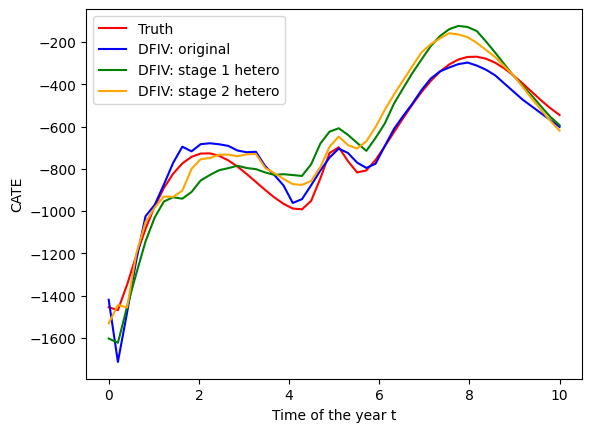

In [62]:
fig, ax = plt.subplots()
time = time.squeeze()
l1 = ax.plot(time, true_demand, color='red', label='Truth')
l2 = ax.plot(time, original_demand, color='blue', label='DFIV: original')
l3 = ax.plot(time, stage_1_pred_demand, color='green', label='DFIV: stage 1 hetero')
l4 = ax.plot(time, stage_2_pred_demand, color='orange', label='DFIV: stage 2 hetero')
ax.legend()

ax.set_xlabel('Time of the year t')
ax.set_ylabel('CATE')
plt.savefig(f'images/CATE_HST.pdf')
plt.show()

# ATE

In [32]:
# vary p: fix t = E[t] = 5, S = E[S] = 4
emotion_range = np.array([1, 2, 3, 4, 5, 6, 7])
price = np.ones(num_point) * np.linspace(10, 25, num_point)
time = np.linspace(0.0, 10, num_point)
emotion = (np.ones(num_point) * np.mean(emotion_range))
covariate = np.c_[time, emotion]

In [33]:
G = np.mean(psi(time)) * np.mean(emotion_range)
coef = G - 2
offset = 100 + 10 * G

true_demand = coef * price + offset

In [ ]:
# # vary p: fix t = E[t] = 5, S = E[S] = 4
# emotion_range = np.array([1, 2, 3, 4, 5, 6, 7])
# price_val = np.linspace(10, 25, num_point)
# price = np.ones(num_point) * price_val
# time = np.array([5] * num_point)
# emotion = (np.ones(num_point) * np.mean(emotion_range))
# covariate = np.c_[time, emotion]

In [44]:
original_demand = []
for p in price:
    p = (np.ones(num_point) * p)[:, np.newaxis]
    pred = np.mean((predict_dfiv_model(dfiv_original_model, p, covariate)))
    original_demand.append(pred)

stage_1_pred_demand = []
for p in price:
    p = (np.ones(num_point) * p)[:, np.newaxis]
    pred = np.mean((predict_dfiv_model(dfiv_hetero_stage_1_model, p, covariate)))
    stage_1_pred_demand.append(pred)
    
stage_2_pred_demand = []
for p in price:
    p = (np.ones(num_point) * p)[:, np.newaxis]
    pred = np.mean((predict_dfiv_model(dfiv_hetero_stage_2_model, p, covariate)))
    stage_2_pred_demand.append(pred)

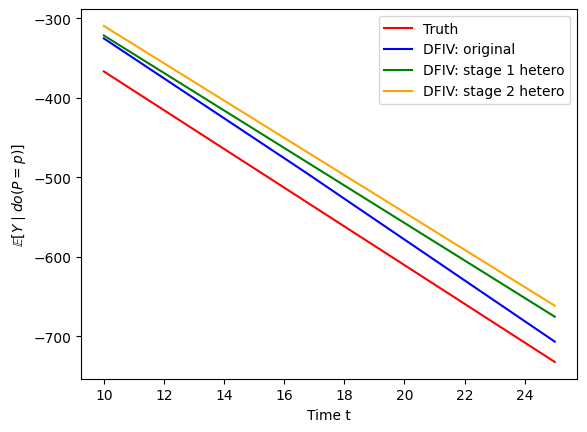

In [53]:
fig, ax = plt.subplots()
price = price.squeeze()
l1 = ax.plot(price, true_demand, color='red', label='Truth')
l2 = ax.plot(price, original_demand, color='blue', label='DFIV: original')
l3 = ax.plot(price, stage_1_pred_demand, color='green', label='DFIV: stage 1 hetero')
l4 = ax.plot(price, stage_2_pred_demand, color='orange', label='DFIV: stage 2 hetero')
ax.legend()

ax.set_xlabel('Time t')
ax.set_ylabel('$\mathbb{E}[Y\mid do(P=p)]$')
plt.savefig(f'images/ATE_HST.pdf')
plt.show()

# Average DFIV

In [99]:
df_merged = pd.concat([df_original.assign(type='original'),
                       df_stage_1.assign(type='stage_1'),
                       df_stage_2.assign(type='stage_2')])

In [100]:
df_merged.groupby(['type']).mean().reset_index()

,type,sigma,rho,test loss
0,original,0.75,0.5,49544.320542
1,stage_1,0.75,0.5,48913.360780
2,stage_2,0.75,0.5,56578.067604
